In [1]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
import imageio
import cv2
import random

In [2]:
data = np.genfromtxt('training_data.csv', delimiter=',')
add_data = np.genfromtxt('training_data_validation.csv',delimiter = ',')
data = np.vstack([data,add_data])
data = data[data[:,-1]!=-1]
data.shape

(1448, 785)

label = 0.0


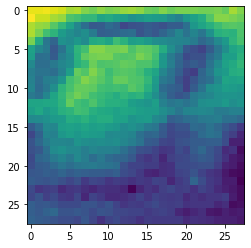

In [3]:
def recover_labeled_img(data,row):
    print("label = {}".format(data[row,-1]))
    plt.imshow(data[row,:-1].reshape((28,28)))
    plt.show()
recover_labeled_img(data,random.randint(0,data.shape[0]))

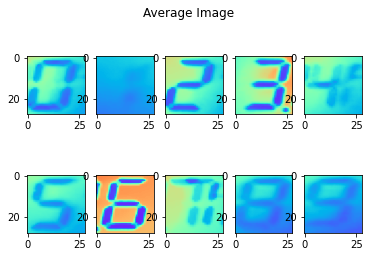

In [4]:
label = 7
def array_avg(label):
    arrays = []
    for i in range(data[data[:,-1] == label].shape[0]):
        arrays.append(data[data[:,-1] == label][i][:784])
    return (sum(arrays)/len(arrays))
f, axes = plt.subplots(ncols = 5,nrows = 2)
axes = axes.flatten()
for i in range(0,10):
    array = array_avg(i)
    axes[i].imshow(array.reshape((28,28)),cmap = 'rainbow',vmax=255,vmin=0)
f.suptitle('Average Image')
plt.show()

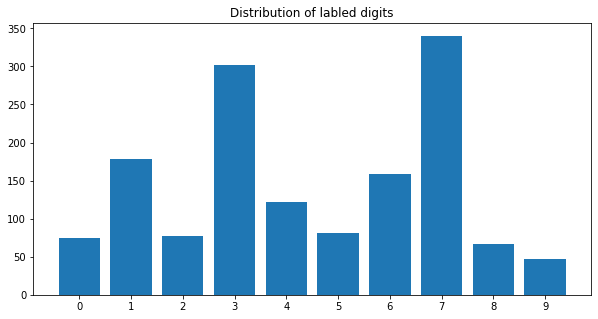

In [5]:
plt.figure(figsize = (10,5))
plt.title('Distribution of labled digits')
labels, counts = np.unique(data[:,-1], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [7]:
from sklearn import preprocessing

X = data[:,:-1]
y= data[:,-1]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=50)

In [9]:
clf = LogisticRegression(C = 0.01, random_state=42,penalty='l2').fit(X_train, y_train)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [10]:
clf.score(X_test,y_test)

0.9916317991631799

In [11]:
y_pred_lr = clf.predict(X_test)

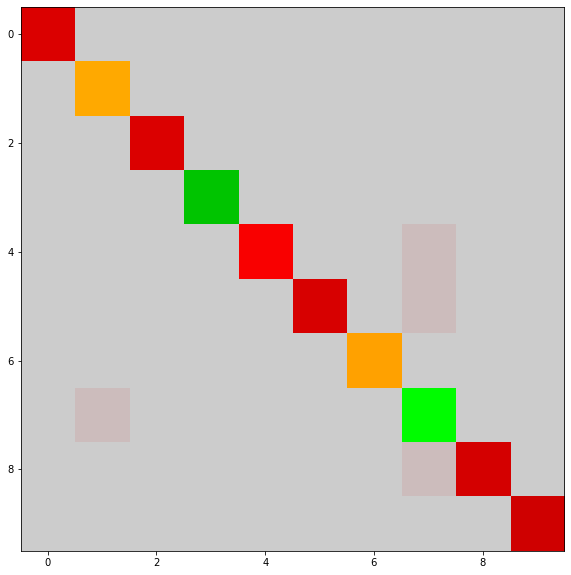

In [83]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(y_test, y_pred_lr),cmap='nipy_spectral_r', vmin=0, vmax=255)

In [13]:
y_test[y_test != y_pred_lr]

array([4., 5., 8., 7.])

In [14]:
from joblib import dump, load
dump(clf, 'logistic_regression.joblib') 


['logistic_regression.joblib']

In [15]:
import tensorflow as tf
import tensorflow.keras as keras

In [16]:
data_1 = data[data[:,-1]!=-1]
y = data_1[:,-1]
X = data_1[:,:-1]/255
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=50)

In [28]:
X[:].shape

(1448, 784)

In [55]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape = (784)))
model.add(keras.layers.Dense(784,activation='relu'))
model.add(keras.layers.Dense(10,activation = 'softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 784)               615440    
                                                                 
 dense_35 (Dense)            (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [56]:
weights, biases = model.layers[1].get_weights()

In [57]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
#loss_fn = keras.losses.CategoricalCrossentropy()
model.compile(loss=loss_fn,
             optimizer = 'adam',
             metrics = ['accuracy'])

Epoch 1/50
31/31 [==============================] - 1s 13ms/step - loss: 1.5760 - accuracy: 0.4639 - val_loss: 1.1315 - val_accuracy: 0.5816
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 1.1096 - accuracy: 0.6216 - val_loss: 0.9681 - val_accuracy: 0.6904
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.9322 - accuracy: 0.6979 - val_loss: 0.7841 - val_accuracy: 0.7427
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.7803 - accuracy: 0.7567 - val_loss: 0.7171 - val_accuracy: 0.7301
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.7066 - accuracy: 0.7835 - val_loss: 0.6250 - val_accuracy: 0.7573
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.5946 - accuracy: 0.8134 - val_loss: 0.5545 - val_accuracy: 0.7908
Epoch 7/50
31/31 [==============================] - 0s 8ms/step - loss: 0.5088 - accuracy: 0.8619 - val_loss: 0.4457 - val_accuracy: 0.8808
Epoch 8/50
31/31

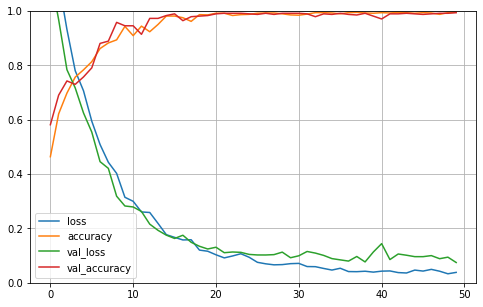

In [58]:
history = model.fit(X_train, y_train, epochs = 50,
                   validation_data = (X_test, y_test))
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

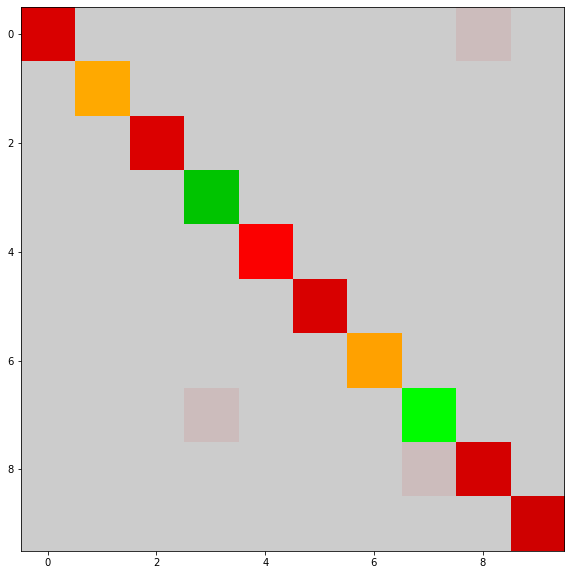

In [82]:
y_pred_nn = model.predict(X_test)
y_pred_nn = [x.argmax() for x in y_pred_nn]
plt.figure(figsize=(10,10))
plt.imshow(confusion_matrix(y_test, y_pred_nn),cmap = 'nipy_spectral_r', vmin=0, vmax=255)
plt.show()

In [60]:
print('labels = ',y_test[y_test != y_pred_nn])
print('predictions = ',np.array(y_pred_nn)[y_pred_nn != y_test])

labels =  [7. 8. 0.]
predictions =  [3 7 8]


In [61]:
nn_model = model
dump(nn_model, 'nn_model.joblib') 

INFO:tensorflow:Assets written to: ram://c3790655-44a3-4c80-93b3-92c5a21d0dda/assets


['nn_model.joblib']

### Radom Gut Check

logistic reg pred = 5.0
nn prediction = 5
nn probabiliy = 0.9700000286102295


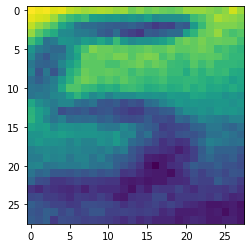

In [68]:
i = random.randint(0,405)
m_prediction = model.predict(X_test[i].reshape(1,-1)).round(2)
lr_pred = clf.predict(X_test[i].reshape(1,-1))[0]
print('logistic reg pred = {}'.format(lr_pred))
print('nn prediction = {}'.format(m_prediction.argmax()))
print('nn probabiliy = {}'.format(m_prediction.max()))
plt.imshow(X_test[i].reshape((28,28)))
plt.show()

### Review Low Confidence Prediction

In [69]:
nn_y_pred = model.predict(X_test).round(2)
low_confidence_prob = []
low_confidence_pred = []
indexes = []
for i,pred in enumerate(nn_y_pred):
    if pred.max()<0.9:
        low_confidence_prob.append(pred.max())
        low_confidence_pred.append(pred.argmax())
        indexes.append(i)
low_confidence = pd.DataFrame()
i = 0
for prob, pred in zip(low_confidence_prob,low_confidence_pred):
    low_confidence.loc[i,'index'] = indexes[i]
    low_confidence.loc[i,'log_reg_probability'] = prob
    low_confidence.loc[i,'prediction'] = pred
    i+=1
low_confidence.sort_values(by = 'log_reg_probability',ascending = False)

,index,log_reg_probability,prediction
3,104.0,0.90,6.0
9,296.0,0.90,1.0
11,336.0,0.90,6.0
12,338.0,0.90,1.0
0,18.0,0.89,1.0
1,26.0,0.89,9.0
5,179.0,0.88,9.0
7,227.0,0.86,1.0
15,468.0,0.86,1.0
14,459.0,0.85,1.0


logistic reg prediction = 6
logistic reg probability = 0.1
nn prediction = 6
nn probabiliy = 0.8399999737739563


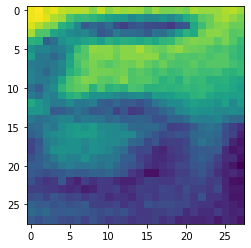

In [75]:
i = 2
m_prediction = model.predict(X_test[indexes[i]].reshape(1,-1)).round(2)
lr_pred = int(clf.predict(X_test[indexes[i]].reshape(1,-1))[0])
lr_prob = round(clf.predict_proba(X_test[indexes[i]].reshape(1,-1)).max(),2)
print('logistic reg prediction = {}'.format(lr_pred))
print('logistic reg probability = {}'.format(lr_prob))
print('nn prediction = {}'.format(low_confidence_pred[i]))
print('nn probabiliy = {}'.format(round(low_confidence_prob[i],2)))
plt.imshow(X_test[indexes[i]].reshape((28,28)))
plt.show()